This is a companions notebook of the paper: [**Justifying Language Model Logarithmic Loss Gain
for Text Summarization via Lossless Compression**
](https://)

The notebook includes all code for result reconstruction as well as general

# Structure



1.   Overview of the summarization task
2.   Summary evaluation task: importance, challenges and familiar metrics
3.   Shannon game
4.   LLG code and evaluation datasets
5.   Information theoretical justifications:
 *   Loseless compression - Arithmetic coding
 *   Normalized compression distance (NCD)
 *   Linguistic analysis: content VS function words


# Summarization task

Automatic text summarization is a core task of Natural Language Processing (NLP). The importance lies in lalala.

Two main summarization types are extractive and abstractive. To demonstrate, in the examples below we generate an abstractive summary using Pegasus model and an extractive summary using LexRank algorithm.

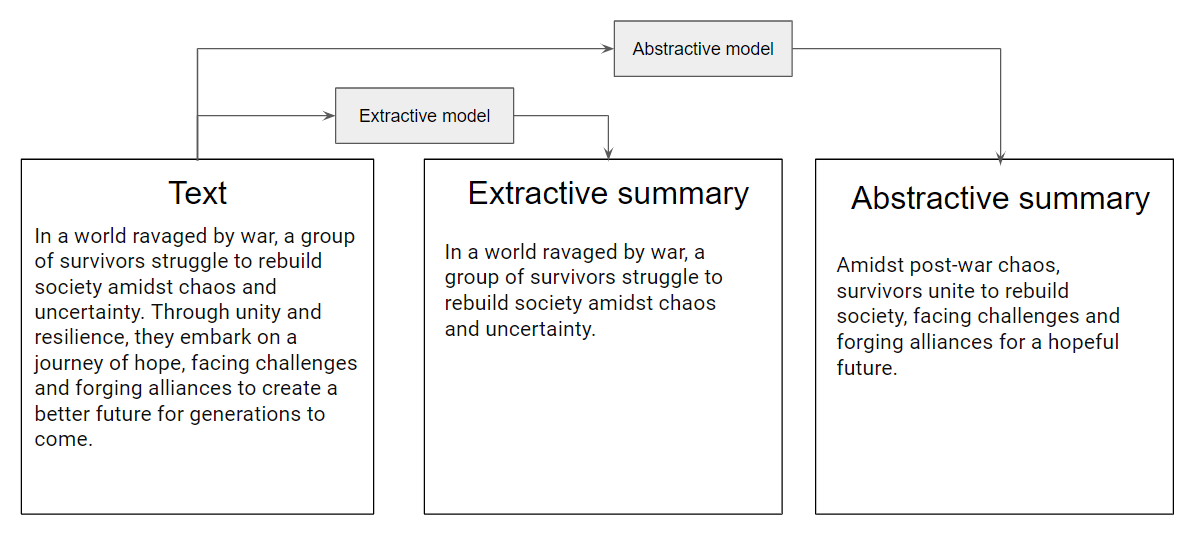

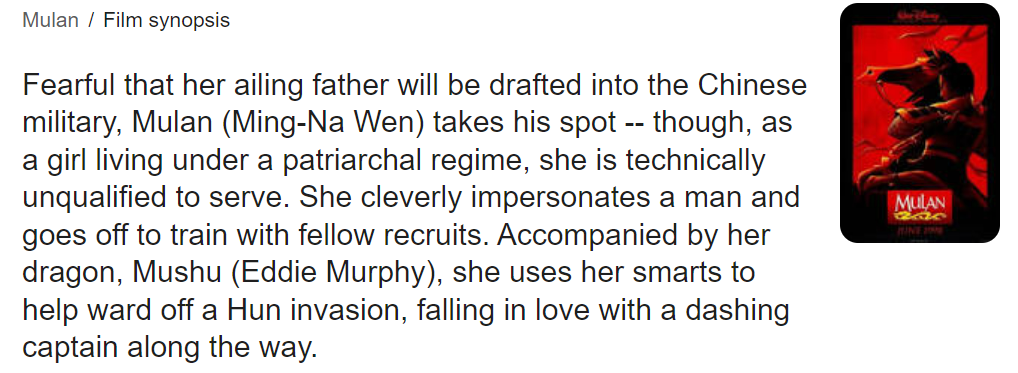

In [ ]:
mulan_text = "Fearful that her ailing father will be drafted into the Chinese military, Mulan (Ming-Na Wen) takes his spot. Though, as a girl living under a patriarchal regime, she is technically unqualified to serve. She cleverly impersonates a man and goes off to train with fellow recruits. Accompanied by her dragon, Mushu (Eddie Murphy), she uses her smarts to help ward off a Hun invasion, falling in love with a dashing captain along the way."

In [ ]:
%%capture
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

def summarize_text(input_text, model_name="google/pegasus-xsum"):
    # Load the tokenizer and model
    tokenizer = PegasusTokenizer.from_pretrained(model_name)
    model = PegasusForConditionalGeneration.from_pretrained(model_name)

    # Encode the text into tensor of tokens
    tokens = tokenizer(input_text, truncation=True, padding="longest", return_tensors="pt")

    # Generate the summary
    summary_ids = model.generate(tokens["input_ids"], early_stopping=True)

    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary


In [ ]:
%%capture

# Call the function and print the summary
summary_abst = summarize_text(mulan_text)


In [ ]:
print(mulan_text +"\n\n")

print("Summary abstractive:", summary_abst)


Fearful that her ailing father will be drafted into the Chinese military, Mulan (Ming-Na Wen) takes his spot. Though, as a girl living under a patriarchal regime, she is technically unqualified to serve. She cleverly impersonates a man and goes off to train with fellow recruits. Accompanied by her dragon, Mushu (Eddie Murphy), she uses her smarts to help ward off a Hun invasion, falling in love with a dashing captain along the way.


Summary abstractive: A Disney animation set in ancient China, Mulan tells the story of a young girl who is given the chance to fight for her country.


In [ ]:
%%capture
!pip install sumy
import nltk
nltk.download('punkt')
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer



parser = PlaintextParser.from_string(mulan_text, Tokenizer("english"))


summarizer = LexRankSummarizer()

# Summarize the document with 2 sentences
summary = summarizer(parser.document, 2)

# Print the summary
summary_ext = ""
for sentence in summary:
    summary_ext = summary_ext + str(sentence)


In [ ]:
print(summary_ext)

Fearful that her ailing father will be drafted into the Chinese military, Mulan (Ming-Na Wen) takes his spot.Though, as a girl living under a patriarchal regime, she is technically unqualified to serve.


# Summary Evaluation task


*   Summary evaluation task: given a summary $s$ (extractive or abstractive) and a text $t$/ gold summary $g$ evaluate how infomative $s$ is with respect to $t$/$g$.

*  Benchmark methods include lexical mathcing approaches (ROUGUE), embedding (bertScore) and LM based (QA).

*  Main limitations: lack of semantic understanding and gold standard summary requierment

The task is of a subjective nature as there could be multiple interpetations of what a good summary is. Different domains.

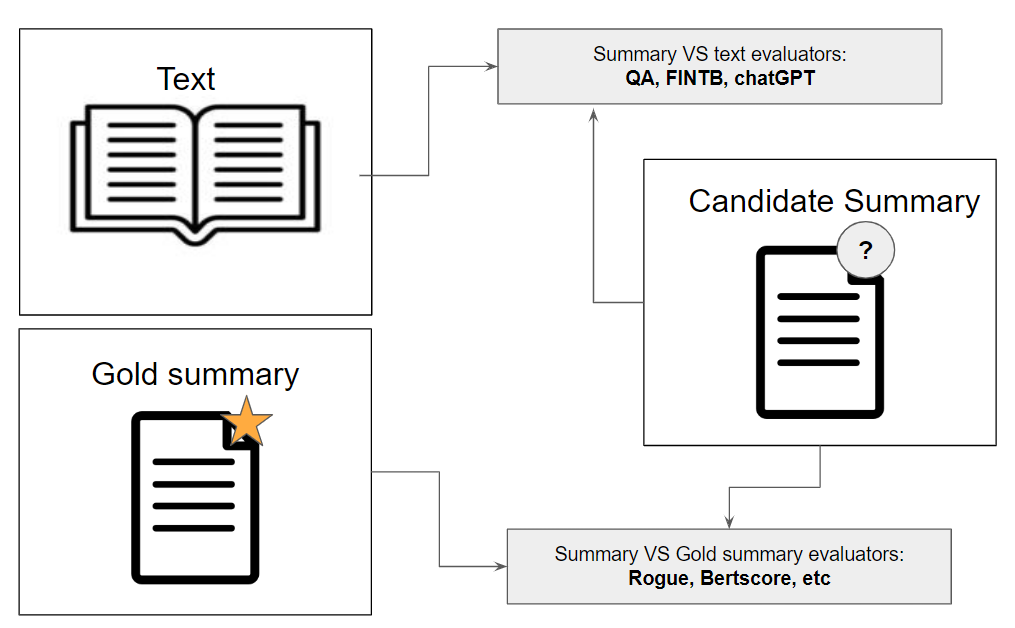

# Shannon game


*   Human subjects guess each letter of a text based on precceding letters.
*   Their Score is the number of guesses.
*   This is done with and without a summary as side information.





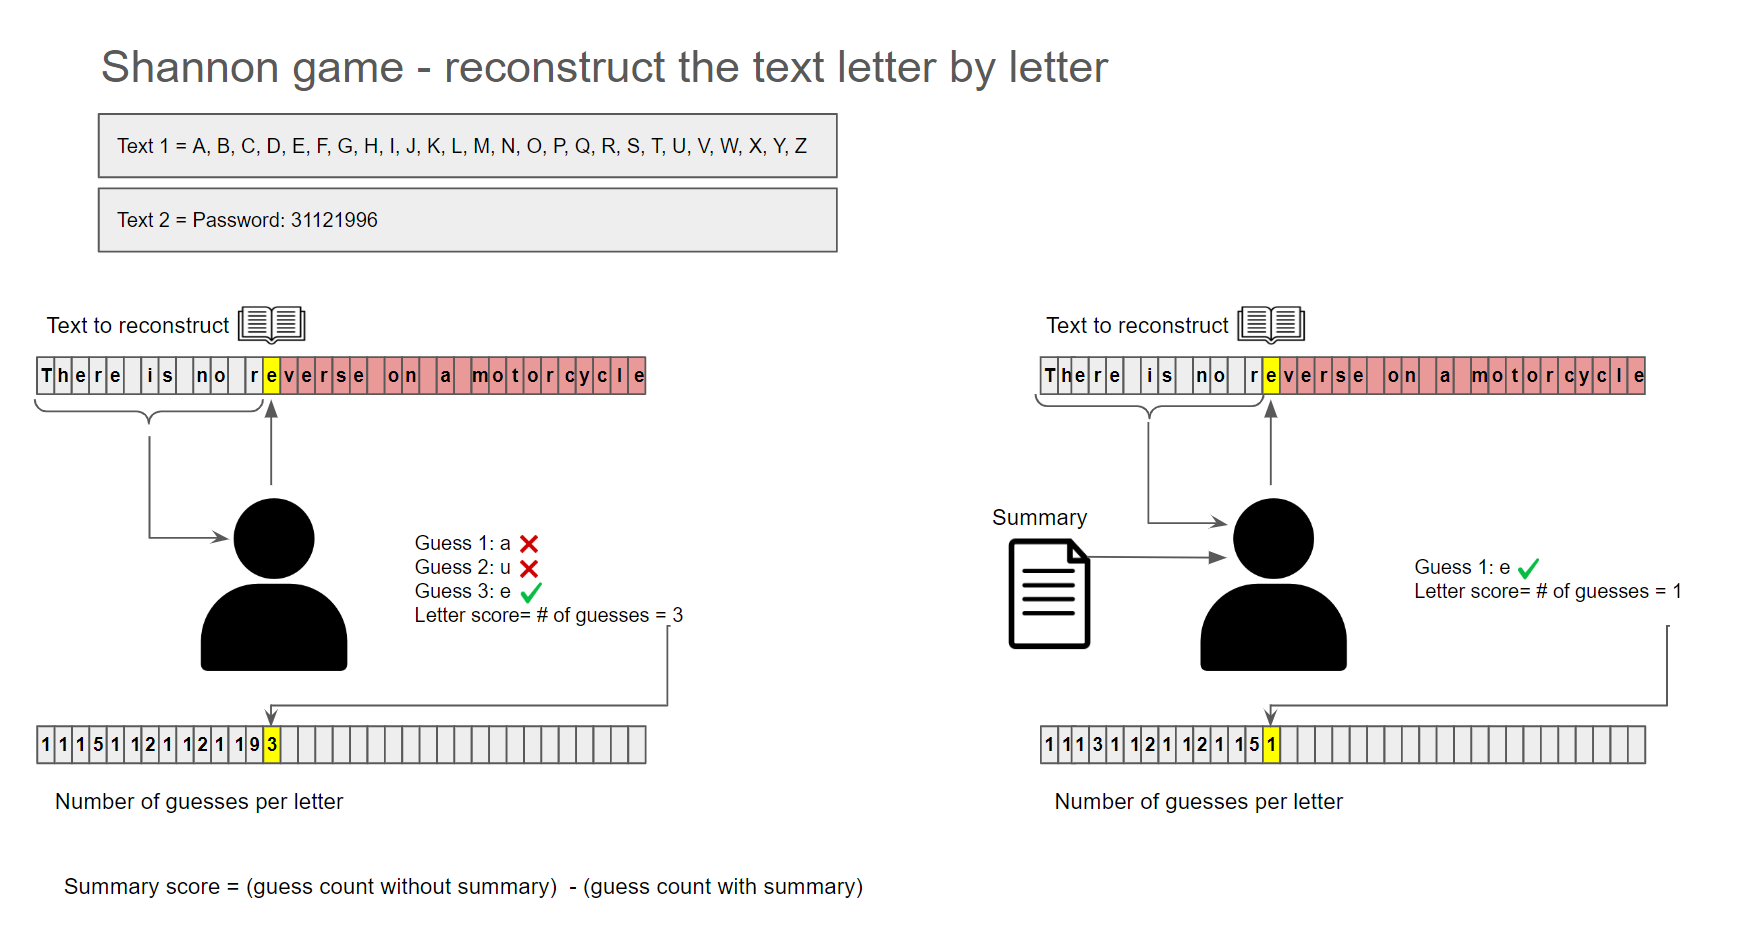

https://www.princeton.edu/~wbialek/rome/refs/shannon_51.pdf

https://aclanthology.org/X98-1026.pdf

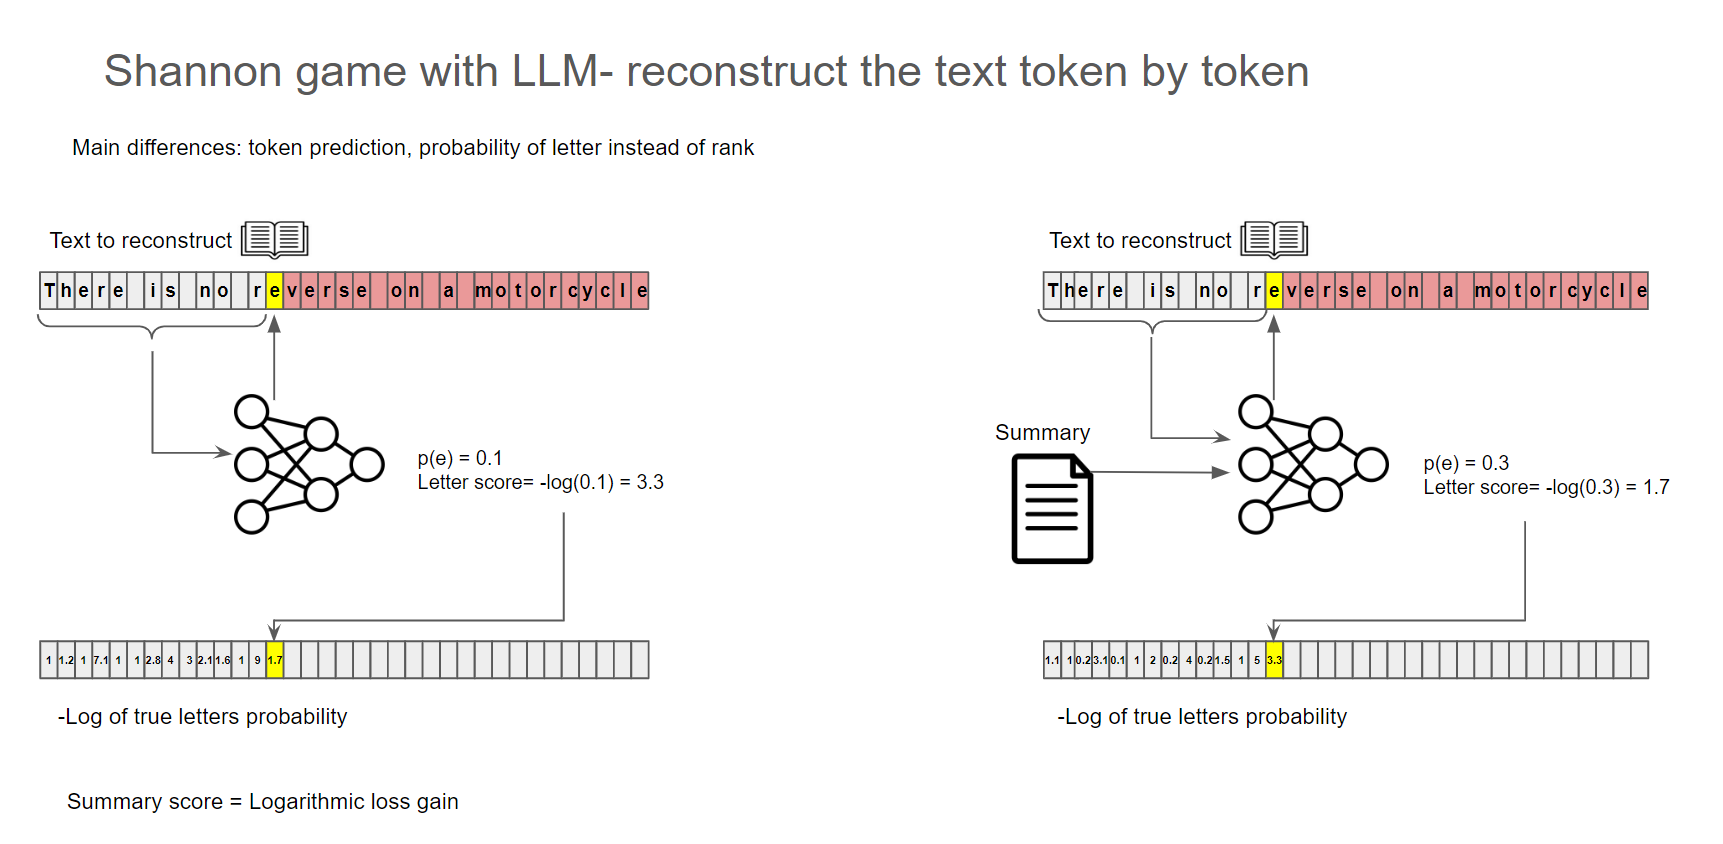

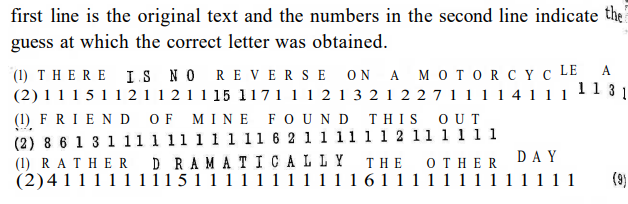

In [ ]:
%%capture
!pip install transformers
!pip install datasets
!pip install ploty
!pip install nltk
!pip install ipywidgets
!pip install spacy
!pip install psutil

In [ ]:
import numpy as np
import json
import datasets
from datasets import load_dataset
from itertools import chain
from collections import defaultdict
import pandas as pd
from google.colab import files
import pickle
import gzip
import io
import pickle
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import nltk
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline
import torch
import nltk
import spacy
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import torch.nn.functional as F
from transformers import AutoTokenizer
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# LLG (logarithmic loss gain)

In [ ]:


class LLG_Evaluator:

    def __init__(self):

        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")
        self.model = GPT2LMHeadModel.from_pretrained("gpt2")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.posLanguageModel = spacy.load("en_core_web_sm")
        self.model.to(self.device)
        self.c_pos = ["PROPN", "NOUN", "VERB", "NUM", "ADJ", "ADV"]
        self.f_pos = ["PRON", "DET", "AUX", "PUNCT", "SCONJ", "CCONJ", "SPACE", "PART", "ADP"]
        self.all_pos = ["PROPN", "NOUN", "VERB", "NUM", "ADJ", "ADV", "INTJ", "SYM", "X", "PRON", "DET", "AUX", "PUNCT", "SCONJ", "CCONJ", "SPACE", "PART","ADP"]
        self.counter = 0



    def get_LLG(self, text, summaries):
        print(self.counter)
        self.counter += 1
        results = []
        losses_none, entry_none = self.get_predictions(text,"")
        for summary in summaries:
            losses, entry = self.get_predictions(text, summary)
            NLLG, NLLG_content, NLLG_function, LLG, LLG_content, LLG_function = self.calc_LLG(entry, entry_none)
            results.append({"NLLG":NLLG, "NLLG_content": NLLG_content, "NLLG_function": NLLG_function, "LLG":LLG, "LLG_content":LLG_content,"LLG_function": LLG_function})
        return results

    def calc_LLG(self, entry, entry_none):
        NLLG = self.calc_LLG_by_pos(entry, entry_none, self.all_pos,True)
        NLLG_content = self.calc_LLG_by_pos(entry, entry_none, self.c_pos,True)
        NLLG_function = self.calc_LLG_by_pos(entry, entry_none, self.f_pos,True)
        LLG = self.calc_LLG_by_pos(entry, entry_none, self.all_pos, False)
        LLG_content = self.calc_LLG_by_pos(entry, entry_none, self.c_pos, False)
        LLG_function = self.calc_LLG_by_pos(entry, entry_none, self.f_pos, False)
        print(LLG)
        return NLLG, NLLG_content, NLLG_function, LLG, LLG_content, LLG_function


    def calc_LLG_by_pos(self, entry, entry_none, POS, normalize):
        score, score_none = 0, 0
        for pos in POS:
            score += entry['Loss'][pos]["sum"]
            score_none += entry_none['Loss'][pos]["sum"]
        if normalize: return (score_none - score) / score_none
        else: return score_none - score




    def get_predictions(self, text, summary):
        """
    Evaluates summary against text by evaluating how well the LM predicts text when
    summary is given as context.

    Args:
    text (string): the full text against which we evaluate the summary.
    summary (string): summary to be evaluated.

    Returns:
    losses (list): List of loss value of all tokens in text with summary as context
    entry (dictionary): loss, entropy and probability values of all tokens in text separated into
    each POS (part of speach). Used to analyse impact of content VS function.
    """
        print(summary)
        if len(summary) == 0: summary = self.tokenizer.bos_token
        else: summary = self.tokenizer.bos_token + summary
        entry = get_initial_entry()
        losses, entropies, probs = [], [], []
        sentences = sent_tokenize(text)
        for sentence in sentences:
            # enter space between summary and sentence to be evaluated text = " " + sentence
            # get_window_predictions returns array of values
            # for each token + updated entry which accumulates values by POS
            sentence_losses, entry = self.get_window_predictions(text=" " + sentence, summary=summary, entry=entry)
            losses.extend(sentence_losses)

        return losses, entry

    def get_window_predictions(self, text, summary, entry):
        """
    Evaluates sentence of text using summary as side information
    Calculate values (loss, probability and entropy) of each token and add them to entry according to their pos

    Args:
    text (string): the full text against which we evaluate the summary.
    summary (string): summary to be evaluated.
    entry (dictionary): updated dictionary - loss, entropy and probability values of all tokens in text separated into
    each POS (part of speach). Used to analyse impact of content VS function.

    Returns:
    losses (list): List of loss value of all tokens in current sentence with summary as context
    entry (dictionary): loss, entropy and probability values of all tokens in current sentence separated into
    each POS (part of speach). Used to analyse impact of content VS function.
    """

        token_indices = self.tokenizer([text], return_offsets_mapping=True)  # tokenize text to get char indices of each token (gpt2 tokenizer)
        token_text = (self.tokenizer.convert_ids_to_tokens(token_indices["input_ids"][0]))  # turn token ids to text
        gpt2_tokens = [(x, (y[0]+1,y[1])) if x[0] == 'Ġ' else (x, (y[0],y[1])) for x, y in zip(token_text, token_indices["offset_mapping"][0])]  # get list of (x= gpt2 text token,y=(start idx, end idx))
        # in gpt2 tokenizer if a word is perceeded by space, 'Ġ' is a part of the token while in spacy it is not, the +1 is a correction for that case for better matching
        text_pos = self.posLanguageModel(text)  # get pos of each token in text
        spacy_tokens = [(token.text, token.idx, token.idx + len(token), token.pos_) for token in text_pos] #get list of (spacy token text, token start idx, token end idx, and pos)

        # print(gpt2_tokens)
        # print(spacy_tokens)

        pos_token_list = []
        for gpt2_token in gpt2_tokens:
            max_token_range, max_pos = max(
                ((min(gpt2_token[1][1], spacy_token[2]) - max(gpt2_token[1][0], spacy_token[1]), spacy_token[3]) for
                 spacy_token in spacy_tokens), key=lambda x: x[0])
            pos_token_list.append((max_pos, gpt2_token))

        # print(pos_token_list)

        losses = []


        input_ids_context = self.tokenizer.encode(summary, return_tensors="pt")
        input_ids_text = self.tokenizer.encode(text, return_tensors="pt")
        input_ids = torch.cat((input_ids_context, input_ids_text), dim=1) # get tokens of summary + text

        start_index = len(input_ids_context[0])  # start index is first index of text
        end_index = len(input_ids[0])  # end index is last index of summary +text

        #input_ids = torch.tensor(input_ids).to(self.device)  # input ids to GPU
        input_ids = input_ids.clone().detach().to(self.device)
        #tokens_raw = self.tokenizer.convert_ids_to_tokens(input_ids[0, start_index:end_index])  # text tokens of text
        if input_ids.shape[1] >= 1024:
            print("error - text is too long for model's input - returning empty results")
            return losses,entry

        with torch.no_grad():
            outputs = self.model(input_ids)  # forward on input_ids to get logits of each token
            logits = outputs.logits # get logits

        idx_pos = 0  # running index of pos of token
        for k in range(start_index, end_index):  # get values of every token in text

            true_word_id = input_ids[0,k]  # get curr token index
            word_distribution = F.softmax(logits[:, k-1, :], dim=-1)  # get distribution of curr_token k
            # logits(k-1) and not logits(k), because logits(k-1) retrieves distribution of  next token k
            probability_of_word = word_distribution[0, true_word_id]  # get probability of  current true word
            loss = -1*torch.log2(probability_of_word)  # get loss of current word
            losses.append(loss.item())

            pos = pos_token_list[idx_pos][0]  # get POS of current token
            # Update entry, add number of tokens added and their values

            # if loss.item() > 10: entry['Loss'][pos]['sum'] += 10
            # else: entry['Loss'][pos]['sum'] += loss.item()


            entry['Loss'][pos]['sum'] += loss.item()
            entry['Loss'][pos]['length'] += 1


            idx_pos += 1

        return losses, entry

def get_initial_entry():
    entry = {
        "Loss": {},
    }

    categories = [
        "ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ",
        "NOUN", "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ",
        "SYM", "VERB", "X", "SPACE"
    ]

    for category in categories:
        entry["Loss"][category] = {"sum": 0, "length": 0}

    return entry




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
%%capture
# init llg metric
LLG = LLG_Evaluator()

#  NCD Gzip

The results and anlysis will be discussed in NCD section

In [ ]:
def gzipGetBits(x):
  x_bytes = (x).encode('utf-8')

  # Compress the string using gzip
  compressed_data = io.BytesIO()
  with gzip.GzipFile(fileobj=compressed_data, mode='wb') as f:
      f.write(x_bytes)


  compressed_length = compressed_data.tell()
  compressed_length_in_bits = compressed_length * 8
  return(compressed_length_in_bits)


In [ ]:
def ncdGzip(text,summary):
  z_x = gzipGetBits(summary)
  z_y = gzipGetBits(text)
  z_xy = gzipGetBits(summary+text)
  ncd = (z_xy - z_x)/z_y
  return(ncd)

# summEval Dataset

We run all LLG variations and NCD with gzip on summEval dataset

In [ ]:
summEval =  pd.read_json("/content/summEval_dataset.jsonl", lines=True)

In [ ]:
def replace_semicolon(text):
  return text.replace(":",".")

long_text_id = "dm-test-d296270ab4a4cf20f2d9c1aae7514687806f2b35"
summEval.loc[summEval['id'] == long_text_id, 'text'] = summEval[summEval['id'] == long_text_id]['text'].apply(replace_semicolon)

In [ ]:
summEval.rename(columns={'expert_annotations': 'full_annotations'}, inplace = True)
summEval.rename(columns={'decoded': 'summary'}, inplace = True)
summEval.drop(columns=["id", "turker_annotations","filepath","metric_scores_1","metric_scores_6","metric_scores_11","references"], inplace=True)
summEval = summEval[["text","summary","full_annotations","model_id"]]

In [ ]:
def get_mean_annotations(annotations):
  mean_annotations = {key: sum(d[key] for d in annotations) / len(annotations) for key in annotations[0]}
  return [mean_annotations]

summEval["annotations"] = summEval["full_annotations"].apply(get_mean_annotations)

In [ ]:
summEval.head(3)

,text,summary,annotations,model_id,llg,full_annotations
0,Chelsea have made an offer for FC Tokyo's 22-y...,chelsea have made an offer for fc tokyo 's dut...,"[{'coherence': 2.0, 'consistency': 2.0, 'fluen...",M11,"[{'NLLG': 0.07995063706918161, 'NLLG_content':...","[{'coherence': 3, 'consistency': 2, 'fluency':..."
1,Paul Merson has restarted his row with Andros ...,paul merson was brought on with only seven min...,"[{'coherence': 1.3333333333333333, 'consistenc...",M11,"[{'NLLG': 0.11346810763486187, 'NLLG_content':...","[{'coherence': 2, 'consistency': 1, 'fluency':..."
2,Paul Merson has restarted his row with Andros ...,paul merson has restarted his row with andros ...,"[{'coherence': 2.3333333333333335, 'consistenc...",M13,"[{'NLLG': 0.10605889043504013, 'NLLG_content':...","[{'coherence': 3, 'consistency': 5, 'fluency':..."


In [ ]:
summEval = summEval.head(18)

In [ ]:
# Run all variations of LLG on summEval dataset

def merge_columns(text, summary, annotations, model_id, llg, full_annotations):
    return [{'text': text,'summary' : summary[i], 'annotations': annotations[i], 'model_id': model_id[i],'llg': [llg[i]], 'full_annotations': full_annotations[i]} for i in range(len(summary))]


grouped_df = summEval.groupby('text').agg({'summary': list, 'annotations': list, "model_id": list, "full_annotations": list}).reset_index()
grouped_df['llg'] = grouped_df.apply(lambda row: LLG.get_LLG(row['text'], row['summary']), axis=1)
grouped_df['merged_column'] = grouped_df.apply(lambda row: merge_columns(row['text'],row['summary'], row['annotations'], row['model_id'], row['llg'], row['full_annotations']), axis=1)
df = grouped_df.drop(['summary', 'text', 'llg', "model_id","annotations","full_annotations"], axis=1)
df = df.explode('merged_column')



summEval = pd.json_normalize(df['merged_column'])



In [ ]:
# Run ncd with gzip on summEval dataset
summEval["ncdGzip"] = summEval.apply(lambda x: ncdGzip(x["text"],x["summary"]), axis=1)

In [ ]:
# save file to pickle and download

summEval.to_pickle('summEval_llg_ncd.pkl')

files.download('summEval_llg_ncd.pkl')

#Learning from human feedback (SSF) : CNN and DailyMail

In [ ]:
%%capture
ssf = load_dataset("openai/summarize_from_feedback", 'axis')

In [ ]:
ssf = ssf['test'].to_pandas()

In [ ]:
remove_compatible = lambda axes: {key: value for key, value in axes.items() if key != 'compatible' and key != "overall"}
ssf['annotations'] = ssf['summary'].apply(lambda x: remove_compatible(x['axes']))
ssf['text'] = ssf['info'].apply(lambda x: x.get('article'))
ssf.rename(columns={'summary': 'summary_details'}, inplace = True)
ssf['summary'] = ssf['summary_details'].apply(lambda x: x.get('text'))
ssf.drop(columns=["split","batch","summary_details","worker"], inplace=True)
ssf = ssf[["text","summary","annotations","info"]]

In [ ]:
ssf.head(4)

,text,summary,annotations,info
0,Newcastle stand-in skipper Moussa Sissoko is f...,Moussa Sissoko was sent off against Liverpool ...,"{'accuracy': 5, 'coverage': 4, 'coherence': 2.0}",{'id': '167f80cc6634b166a699d182e25c81a2349d82...
1,Newcastle stand-in skipper Moussa Sissoko is f...,Newcastle have a mountain to climb in the Prem...,"{'accuracy': 3, 'coverage': 1, 'coherence': 1.0}",{'id': '167f80cc6634b166a699d182e25c81a2349d82...
2,Newcastle stand-in skipper Moussa Sissoko is f...,Moussa Sissoko has been sent off following a d...,"{'accuracy': 4, 'coverage': 2, 'coherence': 2.0}",{'id': '167f80cc6634b166a699d182e25c81a2349d82...
3,Newcastle stand-in skipper Moussa Sissoko is f...,Moussa Sissoko is facing a disciplinary action...,"{'accuracy': 7, 'coverage': 3, 'coherence': 6.0}",{'id': '167f80cc6634b166a699d182e25c81a2349d82...


In [ ]:
# Run all variations of LLG on ssf dataset

def merge_columns(text, summary, annotations, info, llg):
    return [{'text': text,'summary' : summary[i], 'annotations': [annotations[i]], 'info': [info[i]],'llg': [llg[i]]} for i in range(len(summary))]


grouped_df = ssf.groupby('text').agg({'summary': list, 'annotations': list, "info": list}).reset_index()
grouped_df['llg'] = grouped_df.apply(lambda row: LLG.get_LLG(row['text'], row['summary']), axis=1)
grouped_df['merged_column'] = grouped_df.apply(lambda row: merge_columns(row['text'],row['summary'], row['annotations'], row['info'], row['llg']), axis=1)
df = grouped_df.drop(['summary', 'text', 'llg', "info","annotations"], axis=1)
df = df.explode('merged_column')



ssf = pd.json_normalize(df['merged_column'])


In [ ]:
ssf.head()

,text,summary,annotations,info,llg,ncdGzip
0,#UporDown?\n\nThat's the trending question on ...,A photo of a cat coming down some stairs has g...,"[{'accuracy': 7, 'coverage': 2, 'coherence': 4}]",[{'id': 'c7a2fff8169408776d5f35229fb5c3fcb9b25...,"[{'NLLG': 0.21239256394485478, 'NLLG_content':...",0.747277
1,#UporDown?\n\nThat's the trending question on ...,"Cat is going up stairs, cat is going down sta...","[{'accuracy': 7, 'coverage': 1, 'coherence': 2}]",[{'id': 'c7a2fff8169408776d5f35229fb5c3fcb9b25...,"[{'NLLG': -0.010316323849177186, 'NLLG_content...",0.915033
2,#UporDown?\n\nThat's the trending question on ...,A cat appears to be going up or down stairs i...,"[{'accuracy': 7, 'coverage': 6, 'coherence': 5}]",[{'id': 'c7a2fff8169408776d5f35229fb5c3fcb9b25...,"[{'NLLG': 0.17937457576564889, 'NLLG_content':...",0.825708
3,#UporDown?\n\nThat's the trending question on ...,The Internet is raging about a cat going #Upo...,"[{'accuracy': 7, 'coverage': 4, 'coherence': 5}]",[{'id': 'c7a2fff8169408776d5f35229fb5c3fcb9b25...,"[{'NLLG': 0.2207099088889067, 'NLLG_content': ...",0.834423
4,"'My, my! At Waterloo Napoleon did surrender,' ...",Abba's Waterloo song is wrong. Napoleon didn'...,"[{'accuracy': 7, 'coverage': 7, 'coherence': 7}]",[{'id': 'eb30c7ef447aa8e41b9d438e5fd615e43bcc4...,"[{'NLLG': 0.08601641996304905, 'NLLG_content':...",0.981544


In [ ]:
# Run ncd with gzip on summEval dataset
ssf["ncdGzip"] = ssf.apply(lambda x: ncdGzip(x["text"],x["summary"]), axis=1)

In [ ]:
# save file to pickle and download

ssf.to_pickle('ssf_llg_ncd.pkl')

files.download('ssf_llg_ncd.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Anlysis

We evaluate pairwise (sample) correlation between human annotations and LLG. We evaluate both Kendall Tau and Pearson correlation. We correlate over "relevance" dimension for summEval and "coverage" dimension for SSF, as they are the dimension closest to "information".

In [ ]:
# upload pickled data

summEval_llg_ncd = pd.read_pickle('summEval_llg_ncd.pkl')
ssf_llg_ncd = pd.read_pickle('ssf_llg_ncd.pkl')

In [ ]:
def cor_with_annotators_llg(df, metric, dim):
  df[dim] = df["annotations"].apply(lambda x: x[0][dim])
  df[metric] = df["llg"].apply(lambda x: x[0][metric])
  annotation_list = df[dim].tolist()
  llg_list = df[metric].tolist()
  df.drop(columns=[dim, metric],inplace = True)
  return round(kendalltau(annotation_list, llg_list)[0],2), round(pearsonr(annotation_list, llg_list)[0],2)


In [ ]:
k_summEval,p_summEval = cor_with_annotators_llg(summEval_llg_ncd, "LLG", "relevance")
k_ssf,p_ssf = cor_with_annotators_llg(ssf_llg_ncd, "LLG", "coverage")

data = {
    'Correlation method': ['KENDALL τ', 'PEARSON'],
    'SummEval': [str(k_summEval), str(p_summEval)],
    'SFF': [str(k_ssf), str(p_ssf)]
}

print(tabulate(pd.DataFrame(data), headers='keys', tablefmt='pretty', showindex=False))


+--------------------+----------+------+
| Correlation method | SummEval | SFF  |
+--------------------+----------+------+
|     KENDALL τ      |   0.24   | 0.2  |
|      PEARSON       |   0.34   | 0.27 |
+--------------------+----------+------+


# Information Theoretical Justifications

# Loseless Compression with side information (Arithmetic coding)

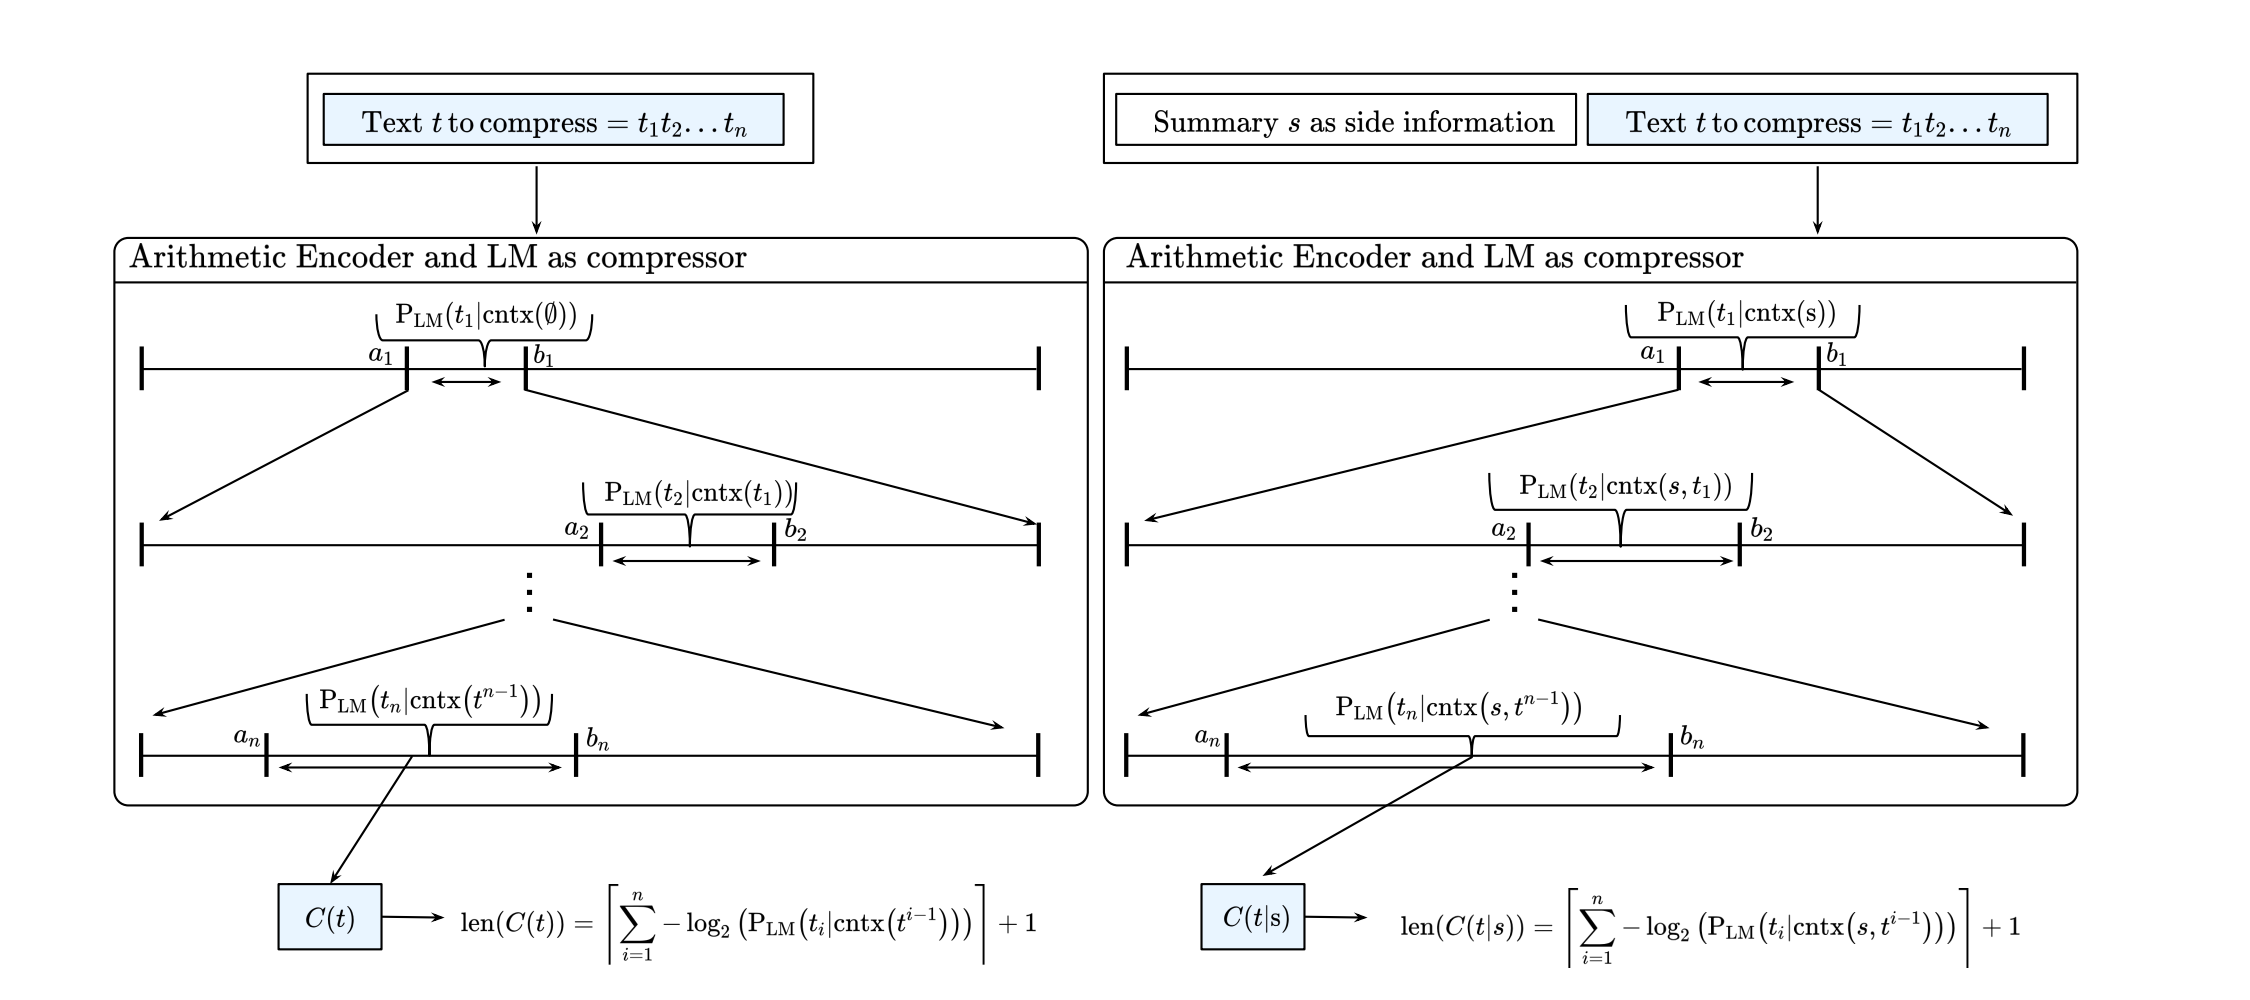

To select a point within the interval we take the first $⌈-\text{log}p(t^{n})⌉+1$ of the mid point of the interval.



C(t) - binary code of compressing t

$⌈\text{logloss(t)⌉}+1 = \text{len}(C(t))$

$⌈\text{logloss(t|s)⌉}+1 = \text{len}(C(t|s))$

###$LLG(t, s) = \text{logloss}(t) - \text{logloss}(t|s) ≈ len(C(t)) - len(C(t|s))$

# Normalized Compression Distance (NCD)

$ NCD_{Z}(x,y) = \frac{Z(xy) - \min\{Z(x),Z(y)\}}{\max\{Z(x),Z(y)\}}$

NCD's score is in the range 0-1. 0 indicates obejects are identical.

Example:


$ NCD_{Z}(x,x) = \frac{Z(xx) - Z(x)}{Z(x)} $≈$ \frac{Z(x) - Z(x)}{Z(x)} = 0$

Suppose x and contains no information about y and Z(x) < Z(y):

$ NCD_{Z}(x,y) = \frac{Z(xy) - Z(x)}{Z(y)} = \frac{Z(x)+z(y) - Z(x)}{Z(y)} = \frac{Z(y)}{Z(y)} = 1$


\\

$LLG(t, s) = \text{logloss}(t) - \text{logloss}(t|s)$

$NLLG(t,s) := \frac{logloss(t) - logloss(t|s)}{logloss(t)}= \frac{lenC(t) - lenC(t|s)}{lenC(t)}$


$\begin{align*}
NCD_{C}(s,t) & = \frac{len{C(s,t)} - \min\{len{C(s)},len{C(t)}\}}{\max\{len{C(s)},len{C(t)}\}} \\
& = \frac{len{C(s,t)} - len{C(s)}}{len{C(t)}} \\
& = \frac{len{C(s)} + len{C(t|s)} - len{C(s)}}{len{C(t)}} \\
& = \frac{len{C(t|s)}}{len{C(t)}} = 1 - NLLG(t|s).
\end{align*}$

In [ ]:
def cor_with_annotators_gzip(df, dim):
  df[dim] = df["annotations"].apply(lambda x: x[0][dim])
  gzip_list = df["ncdGzip"].tolist()
  annotation_list = df[dim].tolist()
  df.drop(columns=[dim],inplace = True)
  return round(kendalltau(annotation_list, gzip_list)[0],2), round(pearsonr(annotation_list, gzip_list)[0],2)

In [ ]:
def cor_llg_gzip(df,metric):
  df[metric] = df["llg"].apply(lambda x: x[0][metric])
  gzip_list = df["ncdGzip"].tolist()
  llg_list = df[metric].tolist()
  df.drop(columns=[metric],inplace = True)
  return round(kendalltau(llg_list, gzip_list)[0],2), round(pearsonr(llg_list, gzip_list)[0],2)

In the following table we show that NLLG and NCD with gzip have high correlation.

In [ ]:
k_gzipnllg_se,p_gzipnllg_se = cor_llg_gzip(summEval_llg_ncd, "NLLG")
k_gzipnllg_ssf,p_gzipnllg_ssf = cor_llg_gzip(ssf_llg_ncd, "NLLG")


data = {
    'Correlation method': ['KENDALL τ', 'PEARSON'],
    'SummEval': [str(k_gzipnllg_se), str(p_gzipnllg_se)],
    'SFF': [str(k_gzipnllg_ssf), str(p_gzipnllg_ssf)]
}

print(tabulate(pd.DataFrame(data), headers='keys', tablefmt='pretty', showindex=False))

+--------------------+----------+-------+
| Correlation method | SummEval |  SFF  |
+--------------------+----------+-------+
|     KENDALL τ      |  -0.55   | -0.56 |
|      PEARSON       |  -0.77   | -0.82 |
+--------------------+----------+-------+


In the following table we show that NLLG outperforms NCD with gzip in correlation with human annotators.

In [ ]:
k_gzip_se,p_gzip_se = cor_with_annotators_gzip(summEval_llg_ncd, "relevance")
k_gzip_ssf,p_gzip_ssf = cor_with_annotators_gzip(ssf_llg_ncd, "coverage")
k_nllg_se,p_nllg_se = cor_with_annotators_llg(summEval_llg_ncd, "NLLG", "relevance")
k_nllg_ssf,p_nllg_ssf = cor_with_annotators_llg(ssf_llg_ncd, "NLLG", "coverage")


data = {
    'Metric': ['NLLG', '', 'NCD_gzip', ''],
    'Correlation method': ['KENDALL τ', 'PEARSON', 'KENDALL τ', 'PEARSON'],
    'SummEval': [str(k_nllg_se), str(p_nllg_se), str(k_gzip_se), str(p_gzip_se)],
    'SFF': [str(k_nllg_ssf), str(p_nllg_ssf), str(k_gzip_ssf), str(p_gzip_ssf)]
}



print(tabulate(pd.DataFrame(data), headers='keys', tablefmt='pretty', showindex=False))


+----------+--------------------+----------+-------+
|  Metric  | Correlation method | SummEval |  SFF  |
+----------+--------------------+----------+-------+
|   NLLG   |     KENDALL τ      |   0.25   | 0.29  |
|          |      PEARSON       |   0.37   | 0.41  |
| NCD_gzip |     KENDALL τ      |  -0.18   | -0.26 |
|          |      PEARSON       |  -0.27   | -0.34 |
+----------+--------------------+----------+-------+


# Content and Structure seperation

In some linguistics and information retrieval studies it is
useful to separate the text into function words, associated with
the text’s structure or style, while the rest of the words are
associated with the text’s content [28]–[30];


<font color='blue'>In this</font> <font color='red'>sentence content words</font> <font color='blue'>are in</font> <font color='red'>red</font> <font color='blue'>and</font> <font color='red'>structure words</font> <font color='blue'>are in</font> <font color='red'>blue.</font>


see example in
Figure 2. Although summarization is conceptually associated
with the text’s content, the LLG of (1) considers all tokens
of the text regardless of their association to structure or
content. In what follows, we analyze the contribution of each
token type to the LLG and empirically show that structure
tokens affect very little on LLG. Namely, LLG tends to
ignore information conveyed by the text’s structure which is
a desirable property of a summarization evaluation metric.

The following figure depicts the histograms of LLG, LLGcont, and
LLGstru over all text-summary pairs per dataset. It follows
from this figure that LLG values are similar to LLG_content and
are significantly less affected by LLG_structure.

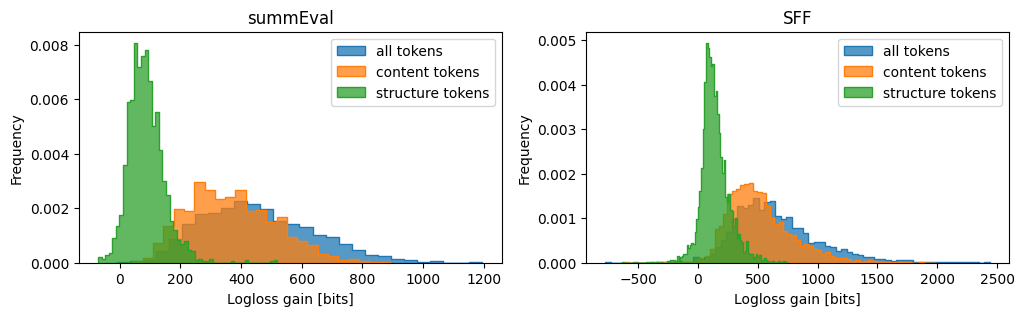

In [ ]:
llg_se = summEval_llg_ncd["llg"].apply(lambda x: x[0]["LLG"]).tolist()
llgc_se = summEval_llg_ncd["llg"].apply(lambda x: x[0]["LLG_content"]).tolist()
llgf_se = summEval_llg_ncd["llg"].apply(lambda x: x[0]["LLG_function"]).tolist()


llg_ssf = ssf_llg_ncd["llg"].apply(lambda x: x[0]["LLG"]).tolist()
llgc_ssf = ssf_llg_ncd["llg"].apply(lambda x: x[0]["LLG_content"]).tolist()
llgf_ssf = ssf_llg_ncd["llg"].apply(lambda x: x[0]["LLG_function"]).tolist()

fig, axs = plt.subplots(1, 2, figsize=(12, 3))


sns.histplot(llg_se, label='all tokens', ax=axs[0], stat="density",element="step")
sns.histplot(llgc_se, label='content tokens', ax=axs[0], stat="density",element="step")
sns.histplot(llgf_se, label='structure tokens', ax=axs[0], stat="density",element="step")

axs[0].set_xlabel('Logloss gain [bits]')
axs[0].set_ylabel('Frequency')
axs[0].legend()
axs[0].set_title("summEval")




sns.histplot(llg_ssf, label='all tokens', ax=axs[1], stat="density",element="step")
sns.histplot(llgc_ssf, label='content tokens', ax=axs[1], stat="density",element="step")
sns.histplot(llgf_ssf, label='structure tokens', ax=axs[1], stat="density",element="step")

axs[1].set_xlabel('Logloss gain [bits]')
axs[1].set_ylabel('Frequency')
axs[1].legend()
axs[1].set_title("SFF")

plt.savefig('histogramsIDiff.pdf', format='pdf', bbox_inches='tight')
plt.show()


We further compare
all LLG variants as summarization metrics by checking their
correlation with human evaluation scores. Table III shows
that LLG correlates with human evaluation very similarly to
LLGcont and both outperform LLGstru. This behavior suggests
that LLG naturally removes the impact of structure tokens
since, in contrast to content tokens, they are about equally
predictable whether or not side information is present. This is
clearly a desired behavior for summary evaluation.

In [ ]:
k_llg_se,p_llg_se = cor_with_annotators_llg(summEval_llg_ncd, "LLG", "relevance")
k_llg_ssf,p_llg_ssf = cor_with_annotators_llg(ssf_llg_ncd, "LLG", "coverage")

k_llgc_se,p_llgc_se = cor_with_annotators_llg(summEval_llg_ncd, "LLG_content", "relevance")
k_llgc_ssf,p_llgc_ssf = cor_with_annotators_llg(ssf_llg_ncd, "LLG_content", "coverage")

k_llgf_se,p_llgf_se = cor_with_annotators_llg(summEval_llg_ncd, "LLG_function", "relevance")
k_llgf_ssf,p_llgf_ssf = cor_with_annotators_llg(ssf_llg_ncd, "LLG_function", "coverage")



data = {
    'Metric': ['LLG', '', 'LLG_content', '', "LLG_function", ''],
    'Correlation method': ['KENDALL τ', 'PEARSON', 'KENDALL τ', 'PEARSON', 'KENDALL τ', 'PEARSON'],
    'SummEval': [str(k_llg_se), str(p_llg_se), str(k_llgc_se), str(p_llgc_se), str(k_llgf_se), str(p_llgf_se)],
    'SFF': [str(k_llg_ssf), str(p_llg_ssf), str(k_llgc_ssf), str(p_llgc_ssf), str(k_llgf_ssf), str(p_llgf_ssf)]
}




print(tabulate(pd.DataFrame(data), headers='keys', tablefmt='pretty', showindex=False))

+--------------+--------------------+----------+------+
|    Metric    | Correlation method | SummEval | SFF  |
+--------------+--------------------+----------+------+
|     LLG      |     KENDALL τ      |   0.24   | 0.2  |
|              |      PEARSON       |   0.34   | 0.27 |
| LLG_content  |     KENDALL τ      |   0.22   | 0.21 |
|              |      PEARSON       |   0.32   | 0.29 |
| LLG_function |     KENDALL τ      |   0.18   | 0.12 |
|              |      PEARSON       |   0.28   | 0.17 |
+--------------+--------------------+----------+------+


In [ ]:
ssf_llg_ncd.head()

,text,summary,annotations,info,llg,ncdGzip,text_wc
0,#UporDown?\n\nThat's the trending question on ...,A photo of a cat coming down some stairs has g...,"[{'accuracy': 7, 'coverage': 2, 'coherence': 4}]",[{'id': 'c7a2fff8169408776d5f35229fb5c3fcb9b25...,"[{'NLLG': 0.21239256394485478, 'NLLG_content':...",0.747277,131
1,#UporDown?\n\nThat's the trending question on ...,"Cat is going up stairs, cat is going down sta...","[{'accuracy': 7, 'coverage': 1, 'coherence': 2}]",[{'id': 'c7a2fff8169408776d5f35229fb5c3fcb9b25...,"[{'NLLG': -0.010316323849177186, 'NLLG_content...",0.915033,131
2,#UporDown?\n\nThat's the trending question on ...,A cat appears to be going up or down stairs i...,"[{'accuracy': 7, 'coverage': 6, 'coherence': 5}]",[{'id': 'c7a2fff8169408776d5f35229fb5c3fcb9b25...,"[{'NLLG': 0.17937457576564889, 'NLLG_content':...",0.825708,131
3,#UporDown?\n\nThat's the trending question on ...,The Internet is raging about a cat going #Upo...,"[{'accuracy': 7, 'coverage': 4, 'coherence': 5}]",[{'id': 'c7a2fff8169408776d5f35229fb5c3fcb9b25...,"[{'NLLG': 0.2207099088889067, 'NLLG_content': ...",0.834423,131
4,"'My, my! At Waterloo Napoleon did surrender,' ...",Abba's Waterloo song is wrong. Napoleon didn'...,"[{'accuracy': 7, 'coverage': 7, 'coherence': 7}]",[{'id': 'eb30c7ef447aa8e41b9d438e5fd615e43bcc4...,"[{'NLLG': 0.08601641996304905, 'NLLG_content':...",0.981544,1588


In [ ]:
ssf_llg_ncd["text_wc"] = ssf_llg_ncd["text"].apply(lambda x: len(x.split()))

316.5419691791501


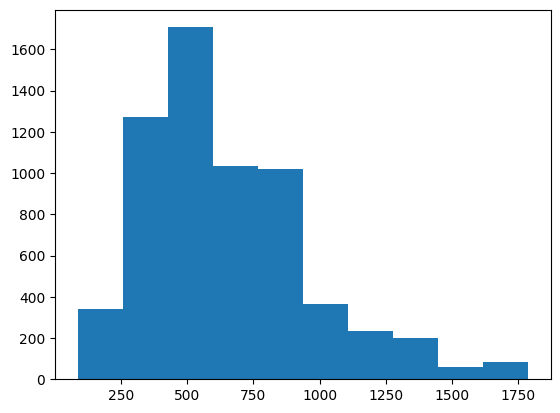

In [ ]:
print(np.std(ssf_llg_ncd["text_wc"]))
plt.hist(ssf_llg_ncd["text_wc"])
plt.show()

In [ ]:
summEval_llg_ncd["text_wc"] = summEval_llg_ncd["text"].apply(lambda x: len(x.split()))

102.56569163224123


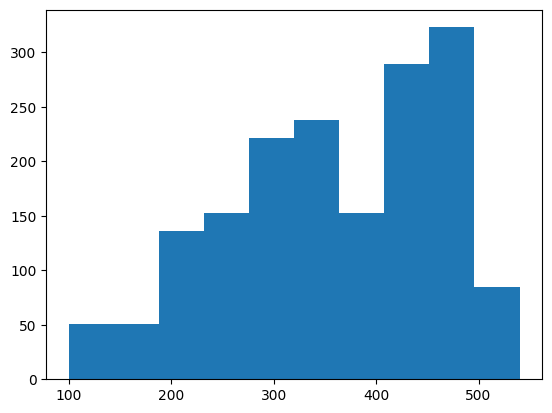

In [ ]:
print(np.std(summEval_llg_ncd["text_wc"]))
plt.hist(summEval_llg_ncd["text_wc"])
plt.show()

In [ ]:
!pip install rouge

In [ ]:
summEval_llg_ncd.head()

,text,summary,full_annotations,model_id,llg,ncdGzip,annotations,text_wc
0,(CNN)A North Pacific gray whale has earned a s...,north pacific gray whale has earned a spot in ...,"[{'coherence': 1, 'consistency': 1, 'fluency':...",M11,"[{'NLLG': 0.17891696236255647, 'NLLG_content':...",0.834711,"[{'coherence': 1.3333333333333333, 'consistenc...",293
1,(CNN)A North Pacific gray whale has earned a s...,a north pacific gray whale has earned a spot i...,"[{'coherence': 5, 'consistency': 5, 'fluency':...",M13,"[{'NLLG': 0.2402755988763883, 'NLLG_content': ...",0.814050,"[{'coherence': 4.666666666666667, 'consistency...",293
2,(CNN)A North Pacific gray whale has earned a s...,-lrb- cnn -rrb- a north pacific gray whale has...,"[{'coherence': 4, 'consistency': 5, 'fluency':...",M1,"[{'NLLG': 0.2869963924705202, 'NLLG_content': ...",0.746901,"[{'coherence': 3.6666666666666665, 'consistenc...",293
3,(CNN)A North Pacific gray whale has earned a s...,"the whale , named varvara , swam nearly 14,000...","[{'coherence': 4, 'consistency': 3, 'fluency':...",M14,"[{'NLLG': 0.2305821912328826, 'NLLG_content': ...",0.821281,"[{'coherence': 4.0, 'consistency': 4.333333333...",293
4,(CNN)A North Pacific gray whale has earned a s...,"north pacific gray whale swam nearly 14,000 mi...","[{'coherence': 4, 'consistency': 5, 'fluency':...",M15,"[{'NLLG': 0.2045353325029239, 'NLLG_content': ...",0.862603,"[{'coherence': 4.0, 'consistency': 5.0, 'fluen...",293


In [ ]:
def count_extract(row,rouge):
  text = row["text"].lower()
  summary = row["summary"].lower()
  scores = rouge.get_scores(summary, text)
  print("ROUGE scores:", scores[0]["rouge-2"]['p'])

  return scores[0]["rouge-2"]['p']


In [ ]:
rougue = Rouge()
summEval_llg_ncd["rouge-2"] = summEval_llg_ncd.apply(count_extract, args=(rougue,), axis=1)

ROUGE scores: 0.65
ROUGE scores: 0.7413793103448276
ROUGE scores: 0.6868686868686869
ROUGE scores: 0.7037037037037037
ROUGE scores: 0.5681818181818182
ROUGE scores: 0.5609756097560976
ROUGE scores: 0.6714285714285714
ROUGE scores: 0.6842105263157895
ROUGE scores: 0.25
ROUGE scores: 0.8529411764705882
ROUGE scores: 0.6301369863013698
ROUGE scores: 0.6774193548387096
ROUGE scores: 0.6046511627906976
ROUGE scores: 0.6818181818181818
ROUGE scores: 0.65
ROUGE scores: 0.64
ROUGE scores: 0.5789473684210527
ROUGE scores: 0.7083333333333334
ROUGE scores: 0.7959183673469388
ROUGE scores: 0.8
ROUGE scores: 0.71875
ROUGE scores: 0.7435897435897436
ROUGE scores: 0.8292682926829268
ROUGE scores: 0.8305084745762712
ROUGE scores: 0.7555555555555555
ROUGE scores: 0.8571428571428571
ROUGE scores: 0.95
ROUGE scores: 0.7894736842105263
ROUGE scores: 0.7619047619047619
ROUGE scores: 0.8222222222222222
ROUGE scores: 0.75
ROUGE scores: 0.7692307692307693
ROUGE scores: 0.7727272727272727
ROUGE scores: 0.63157

In [ ]:
hypothesis = summEval_llg_ncd.iloc[0]["summary"].lower()
reference = summEval_llg_ncd.iloc[0]["text"].lower()


In [ ]:
print(hypothesis)
print(reference)

north pacific gray whale has earned a spot in the record for the longest migration of a mammal ever recorded . the whale , named varvara , swam nearly 14,000 miles from the guinness worlds records . the record was set by a whale whale whale that swam a mere 10,190-mile round trip . the north coast of mexico is russian for `` barbara '' '' .
(cnn)a north pacific gray whale has earned a spot in the record books after completing the longest migration of a mammal ever recorded. the whale, named varvara, swam nearly 14,000 miles (22,500 kilometers), according to a release from oregon state university, whose scientists helped conduct the whale-tracking study. varvara, which is russian for "barbara," left her primary feeding ground off russia's sakhalin island to cross the  pacific ocean and down the west coast of the united states to baja, mexico. varvara's journey surpassed a record listed on the guinness worlds records website. it said the previous record was set by a humpback whale that s

In [ ]:
from rouge import Rouge

def calculate_rouge(hypothesis, reference):
    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference)
    return scores[0]  # Return the first (and typically only) score

# Example usage
# hypothesis = "the cat sat on the mat"
# reference = "the cat sat on the rug"

rouge_scores = calculate_rouge(hypothesis, reference)
print("ROUGE scores:", rouge_scores["rouge-2"]['p'])


ROUGE scores: 0.65


In [ ]:
summEval_llg_ncd.head()

,text,summary,full_annotations,model_id,llg,ncdGzip,annotations,text_wc,rouge-2
0,(CNN)A North Pacific gray whale has earned a s...,north pacific gray whale has earned a spot in ...,"[{'coherence': 1, 'consistency': 1, 'fluency':...",M11,"[{'NLLG': 0.17891696236255647, 'NLLG_content':...",0.834711,"[{'coherence': 1.3333333333333333, 'consistenc...",293,0.650000
1,(CNN)A North Pacific gray whale has earned a s...,a north pacific gray whale has earned a spot i...,"[{'coherence': 5, 'consistency': 5, 'fluency':...",M13,"[{'NLLG': 0.2402755988763883, 'NLLG_content': ...",0.814050,"[{'coherence': 4.666666666666667, 'consistency...",293,0.741379
2,(CNN)A North Pacific gray whale has earned a s...,-lrb- cnn -rrb- a north pacific gray whale has...,"[{'coherence': 4, 'consistency': 5, 'fluency':...",M1,"[{'NLLG': 0.2869963924705202, 'NLLG_content': ...",0.746901,"[{'coherence': 3.6666666666666665, 'consistenc...",293,0.686869
3,(CNN)A North Pacific gray whale has earned a s...,"the whale , named varvara , swam nearly 14,000...","[{'coherence': 4, 'consistency': 3, 'fluency':...",M14,"[{'NLLG': 0.2305821912328826, 'NLLG_content': ...",0.821281,"[{'coherence': 4.0, 'consistency': 4.333333333...",293,0.703704
4,(CNN)A North Pacific gray whale has earned a s...,"north pacific gray whale swam nearly 14,000 mi...","[{'coherence': 4, 'consistency': 5, 'fluency':...",M15,"[{'NLLG': 0.2045353325029239, 'NLLG_content': ...",0.862603,"[{'coherence': 4.0, 'consistency': 5.0, 'fluen...",293,0.568182


In [ ]:
print(np.mean(summEval_llg_ncd["rouge-2"]))

0.7684129894850246


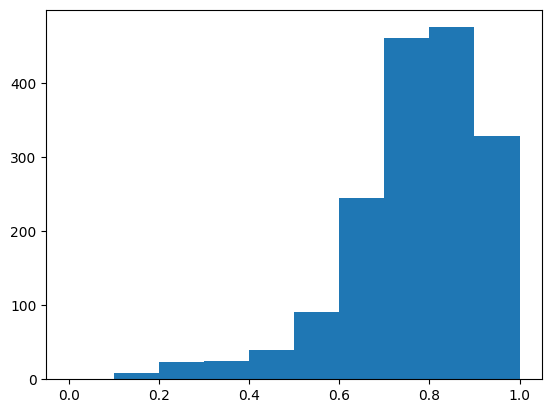

In [ ]:
plt.hist(summEval_llg_ncd["rouge-2"])
plt.show()